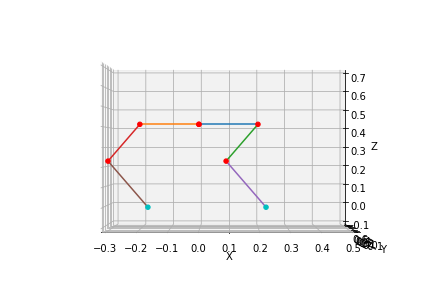

In [1]:
# %%
# Load model.
import os
from jax._src.numpy.lax_numpy import diff
from jax.api import jacfwd

from jax.linear_util import transformation_with_aux
from jbdl.rbdl.utils import ModelWrapper

# CURRENT_PATH = os.path.dirname(os.path.realpath(__file__))
CURRENT_PATH = os.getcwd()
SCRIPTS_PATH = os.path.dirname(CURRENT_PATH)
MODEL_DATA_PATH = os.path.join(SCRIPTS_PATH, "jaxRBDL-2/scripts/model_data") 
mdlw = ModelWrapper()
mdlw.load(os.path.join(MODEL_DATA_PATH, 'half_max_v1.json'))
model = mdlw.model

# %%
# Plot initial state.
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from jbdl.rbdl.tools import plot_model
%matplotlib inline
q = np.array([0.0,  0.4125, 0.0, math.pi/6, math.pi/6, -math.pi/3, -math.pi/3])
fig = plt.figure()
ax = Axes3D(fig)
ax.set_ylim3d(-1.0, 1.0)
plot_model(model, q, ax)
ax.view_init(elev=0,azim=-90)
ax.set_xlabel('X')
ax.set_xlim(-0.3, -0.3+0.8)
ax.set_ylabel('Y')
ax.set_ylim(-0.15, -0.15+0.8)
ax.set_zlabel('Z')
ax.set_zlim(-0.1, -0.1+0.8)
plt.show()

In [2]:
# %%
# Load model parameters.
from jax import device_put
from jbdl.rbdl.utils import xyz2int
NC = int(model["NC"])
NB = int(model["NB"])
nf = int(model["nf"])
contact_cond = model["contact_cond"]
Xtree = device_put(model["Xtree"])
contactpoint = model["contactpoint"],
idcontact = tuple(model["idcontact"])
parent = tuple(model["parent"])
jtype = tuple(model["jtype"])
jaxis = xyz2int(model["jaxis"])
contactpoint = model["contactpoint"]
I = device_put(model["I"])
a_grav = device_put(model["a_grav"])
mu = device_put(0.9)
contact_force_lb = device_put(contact_cond["contact_force_lb"])
contact_force_ub = device_put(contact_cond["contact_force_ub"])
contact_pos_lb = device_put(contact_cond["contact_pos_lb"])
contact_vel_lb = device_put(contact_cond["contact_vel_lb"])
contact_vel_ub = device_put(contact_cond["contact_vel_ub"])
ST = device_put(model["ST"])

In [3]:
# %%
from jbdl.rbdl.dynamics.state_fun_ode import dynamics_fun_extend_core, events_fun_extend_core
import jax.numpy as jnp
from functools import partial
from jax.custom_derivatives import closure_convert
from jbdl.rbdl.contact import detect_contact_core
from jbdl.rbdl.dynamics import composite_rigid_body_algorithm_core
from jbdl.rbdl.contact.impulsive_dynamics import impulsive_dynamics_extend_core

q_star = jnp.array([0.0,  0.0, 0.0, math.pi/6, math.pi/6, -math.pi/3, -math.pi/3])
qdot_star = jnp.array([0.0, 0.0, 0.0, 1.0, 1.0, -1.0, -1.0])
# tau = jnp.zeros((7,))
u = jnp.zeros((4,))

# flag_contact = jnp.array([1, 1])
rankJc = 0
ncp = 0

q = jnp.array([0.0, 0.4125, 0.0, math.pi/6, math.pi/6, -math.pi/3, -math.pi/3])
qdot = jnp.ones((7, ))
x = jnp.hstack([q, qdot])
# xdot, fqp, H = dynamics_fun_core(Xtree, I, q, qdot, contactpoint, tau, a_grav, contact_force_lb, contact_force_ub,\
#     idcontact, flag_contact, parent, jtype, jaxis, NB, NC, nf, rankJc, ncp, mu)

# def dynamics_fun(x, t, Xtree, I, contactpoint, tau, a_grav, contact_force_lb, contact_force_ub, mu,\
#     flag_contact, idcontact,  parent, jtype, jaxis, NB, NC, nf, ncp):
#     q = x[0:NB]
#     qdot = x[NB:]
#     xdot,fqp, H = dynamics_fun_extend_core(Xtree, I, q, qdot, contactpoint, tau, a_grav, contact_force_lb, contact_force_ub,\
#     idcontact, flag_contact, parent, jtype, jaxis, NB, NC, nf, ncp, mu)
#     return xdot

def dynamics_fun(x, t, Xtree, I, contactpoint, u, a_grav, \
    contact_force_lb, contact_force_ub,  contact_pos_lb, contact_vel_lb, contact_vel_ub, mu,\
    ST, idcontact,   parent, jtype, jaxis, NB, NC, nf, ncp):
    q = x[0:NB]
    qdot = x[NB:]
    tau = jnp.matmul(ST, u)
    flag_contact = detect_contact_core(Xtree, q, qdot, contactpoint, contact_pos_lb, contact_vel_lb, contact_vel_ub,\
        idcontact, parent, jtype, jaxis, NC)
    xdot,fqp, H = dynamics_fun_extend_core(Xtree, I, q, qdot, contactpoint, tau, a_grav, contact_force_lb, contact_force_ub,\
    idcontact, flag_contact, parent, jtype, jaxis, NB, NC, nf, ncp, mu)
    return xdot

def events_fun(y, t, Xtree, I, contactpoint, u, a_grav, contact_force_lb, contact_force_ub, \
    contact_pos_lb, contact_vel_lb, contact_vel_ub, mu, ST, idcontact,  parent, jtype, jaxis, NB, NC, nf, ncp):
    q = y[0:NB]
    qdot = y[NB:]
    flag_contact = detect_contact_core(Xtree, q, qdot, contactpoint, contact_pos_lb, contact_vel_lb, contact_vel_ub,\
        idcontact, parent, jtype, jaxis, NC)

    value = events_fun_extend_core(Xtree, q, contactpoint, idcontact, flag_contact, parent, jtype, jaxis, NC)
    return value

def impulsive_dynamics_fun(y, t, Xtree, I, contactpoint, u, a_grav, contact_force_lb, contact_force_ub, \
    contact_pos_lb, contact_vel_lb, contact_vel_ub, mu, ST, idcontact,  parent, jtype, jaxis, NB, NC, nf, ncp):
    q = y[0:NB]
    qdot = y[NB:]
    H =  composite_rigid_body_algorithm_core(Xtree, I, parent, jtype, jaxis, NB, q)
    flag_contact = detect_contact_core(Xtree, q, qdot, contactpoint, contact_pos_lb, contact_vel_lb, contact_vel_ub,\
        idcontact, parent, jtype, jaxis, NC)
    qdot_impulse = impulsive_dynamics_extend_core(Xtree, q, qdot, contactpoint, H, idcontact, flag_contact, parent, jtype, jaxis, NB, NC, nf)
    qdot_impulse = qdot_impulse.flatten()
    y_new = jnp.hstack([q, qdot_impulse])
    return y_new


t = device_put(0.0)
xdot = dynamics_fun(x, t, Xtree, I, contactpoint, u, a_grav, contact_force_lb, contact_force_ub, \
    contact_pos_lb, contact_vel_lb, contact_vel_ub, mu, ST, idcontact,  parent, jtype, jaxis, NB, NC, nf, ncp)

# print(xdot)


pure_dynamics_fun = partial(dynamics_fun, ST=ST, idcontact=idcontact, \
        parent=parent, jtype=jtype, jaxis=jaxis, NB=NB, NC=NC, nf=nf, ncp=ncp)

pure_events_fun = partial(events_fun, ST=ST, idcontact=idcontact, \
        parent=parent, jtype=jtype, jaxis=jaxis, NB=NB, NC=NC, nf=nf, ncp=ncp)

pure_impulsive_fun =  partial(impulsive_dynamics_fun, ST=ST, idcontact=idcontact, \
        parent=parent, jtype=jtype, jaxis=jaxis, NB=NB, NC=NC, nf=nf, ncp=ncp)

pure_args = (x, t, Xtree, I, contactpoint, u, a_grav, contact_force_lb, contact_force_ub,  contact_pos_lb, contact_vel_lb, contact_vel_ub, mu)

# pure_args = (x, t, Xtree, I, contactpoint, tau, a_grav, contact_force_lb, contact_force_ub, mu, flag_contact)

converted, consts = closure_convert(pure_dynamics_fun, *pure_args)
converted, consts = closure_convert(pure_events_fun, *pure_args)
converted, consts = closure_convert(pure_impulsive_fun, *pure_args)

print(pure_dynamics_fun(*pure_args))
print(pure_events_fun(*pure_args))
print(pure_impulsive_fun(*pure_args))



[ 1.          1.          1.          1.          1.          1.
  1.         -0.04471284 -9.916104   -0.20676291 -3.4481804  -1.4350896
  7.9850383   6.980186  ]
1.0
[ 0.          0.4125      0.          0.5235988   0.5235988  -1.0471976
 -1.0471976   1.0000001   0.99999964  0.9999982   0.99999225  1.0000002
  1.0000111   1.0000067 ]


In [4]:
# %%
from jbdl.experimental.ode.solve_ivp import solve_ivp

q0 = jnp.array([0.0,  0.4125, 0.0, math.pi/6, math.pi/6, -math.pi/3, -math.pi/3])
qdot0 = jnp.array([0.0, 0.0, 0.0, 1.0, 1.0, -1.0, -1.0])
x0 = jnp.hstack([q0, qdot0])
t_span = (0.0, 2e-3)
delta_t = 5e-4

pure_args = (Xtree, I, contactpoint, u, a_grav, contact_force_lb, contact_force_ub,  contact_pos_lb, contact_vel_lb, contact_vel_ub, mu)


solve_ivp(pure_dynamics_fun, x0, jnp.linspace(0, 2e-3, 4), pure_events_fun, pure_impulsive_fun, *pure_args)



DeviceArray([[ 0.0000000e+00,  4.1249999e-01,  0.0000000e+00,
               5.2359879e-01,  5.2359879e-01, -1.0471976e+00,
              -1.0471976e+00,  0.0000000e+00,  0.0000000e+00,
               0.0000000e+00,  1.0000000e+00,  1.0000000e+00,
              -1.0000000e+00, -1.0000000e+00],
             [ 0.0000000e+00,  4.1249999e-01,  0.0000000e+00,
               5.2459878e-01,  5.2459878e-01, -1.0481976e+00,
              -1.0481976e+00, -1.1143889e-05, -9.8301237e-03,
              -3.0235098e-05,  9.9989307e-01,  9.9993074e-01,
              -9.9896228e-01, -9.9894637e-01],
             [-1.1143890e-08,  4.1249016e-01, -3.0235100e-08,
               5.2559865e-01,  5.2559870e-01, -1.0491966e+00,
              -1.0491966e+00, -2.2302329e-05, -1.9660227e-02,
              -6.0447303e-05,  9.9978638e-01,  9.9986166e-01,
              -9.9792475e-01, -9.9789274e-01],
             [-1.1143890e-08,  4.1249016e-01, -3.0235100e-08,
               5.2559865e-01,  5.2559870e-01, -1.0491

In [10]:
# %%
import jax
import time
from jax import jacfwd

print(solve_ivp(pure_dynamics_fun, x0, jnp.linspace(0, 2e-3, 4), pure_events_fun, pure_impulsive_fun, *pure_args))
start = time.time()
diff = jax.jit(jacfwd(solve_ivp, argnums=1), static_argnums=(0, 3, 4))
result = diff(pure_dynamics_fun, x0, jnp.linspace(0, 2e-3, 4), pure_events_fun, pure_impulsive_fun, *pure_args)
result.block_until_ready()
duration = time.time() - start
print(duration)

start = time.time()
result = diff(pure_dynamics_fun, x0, jnp.linspace(0, 2e-3, 4), pure_events_fun, pure_impulsive_fun, *pure_args)
result.block_until_ready()
print(result)
duration = time.time() - start
print(duration)

[[ 0.0000000e+00  4.1249999e-01  0.0000000e+00  5.2359879e-01
   5.2359879e-01 -1.0471976e+00 -1.0471976e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  1.0000000e+00  1.0000000e+00
  -1.0000000e+00 -1.0000000e+00]
 [ 0.0000000e+00  4.1249999e-01  0.0000000e+00  5.2459878e-01
   5.2459878e-01 -1.0481976e+00 -1.0481976e+00 -1.1143889e-05
  -9.8301237e-03 -3.0235098e-05  9.9989307e-01  9.9993074e-01
  -9.9896228e-01 -9.9894637e-01]
 [-1.1143890e-08  4.1249016e-01 -3.0235100e-08  5.2559865e-01
   5.2559870e-01 -1.0491966e+00 -1.0491966e+00 -2.2302329e-05
  -1.9660227e-02 -6.0447303e-05  9.9978638e-01  9.9986166e-01
  -9.9792475e-01 -9.9789274e-01]
 [-1.1143890e-08  4.1249016e-01 -3.0235100e-08  5.2559865e-01
   5.2559870e-01 -1.0491966e+00 -1.0491966e+00 -2.2302329e-05
  -1.9660227e-02 -6.0447303e-05  9.9978638e-01  9.9986166e-01
  -9.9792475e-01 -9.9789274e-01]]
1026.7621850967407
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0

In [6]:
u = jnp.ones((4,))
test_pure_args = (Xtree, I, contactpoint, u, a_grav, contact_force_lb, contact_force_ub,  contact_pos_lb, contact_vel_lb, contact_vel_ub, mu)



In [7]:
start = time.time()
result = diff(pure_dynamics_fun, x0, jnp.linspace(0, 2e-3, 4), pure_events_fun, pure_impulsive_fun, *test_pure_args)
result.block_until_ready()
# print("result",result)
duration = time.time() - start
print(duration)

0.007595062255859375


In [8]:
import jax
import time
from jax import jacfwd

print(solve_ivp(pure_dynamics_fun, x0, jnp.linspace(0, 2e-3, 4), pure_events_fun, pure_impulsive_fun, *pure_args))
start = time.time()
diff = jax.jit(jacfwd(solve_ivp, argnums=8), static_argnums=(0, 3, 4))
result = diff(pure_dynamics_fun, x0, jnp.linspace(0, 2e-3, 4), pure_events_fun, pure_impulsive_fun, *pure_args)
result.block_until_ready()
print(result)
duration = time.time() - start
print(duration)



[[ 0.0000000e+00  4.1249999e-01  0.0000000e+00  5.2359879e-01
   5.2359879e-01 -1.0471976e+00 -1.0471976e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  1.0000000e+00  1.0000000e+00
  -1.0000000e+00 -1.0000000e+00]
 [ 0.0000000e+00  4.1249999e-01  0.0000000e+00  5.2459878e-01
   5.2459878e-01 -1.0481976e+00 -1.0481976e+00 -1.1143889e-05
  -9.8301237e-03 -3.0235098e-05  9.9989307e-01  9.9993074e-01
  -9.9896228e-01 -9.9894637e-01]
 [-1.1143890e-08  4.1249016e-01 -3.0235100e-08  5.2559865e-01
   5.2559870e-01 -1.0491966e+00 -1.0491966e+00 -2.2302329e-05
  -1.9660227e-02 -6.0447303e-05  9.9978638e-01  9.9986166e-01
  -9.9792475e-01 -9.9789274e-01]
 [-1.1143890e-08  4.1249016e-01 -3.0235100e-08  5.2559865e-01
   5.2559870e-01 -1.0491966e+00 -1.0491966e+00 -2.2302329e-05
  -1.9660227e-02 -6.0447303e-05  9.9978638e-01  9.9986166e-01
  -9.9792475e-01 -9.9789274e-01]]
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0

In [9]:
start = time.time()
result = diff(pure_dynamics_fun, x0, jnp.linspace(0, 2e-3, 4), pure_events_fun, pure_impulsive_fun, *pure_args)
result.block_until_ready()
duration = time.time() - start
print(duration)

0.006070137023925781
